In [43]:
import gymnasium as gym
import numpy as np
import time
import matplotlib.pyplot as plt

# Question 1: Train a CartPole Agent

In [29]:
# --- Hyperparameters ---
N_EPISODES = 2000
LEARNING_RATE = 0.01
DISCOUNT_FACTOR = 0.99
# 'weights' acts as the agent's policy parameters (4 state features -> 2 actions)
# A more common approach is a neural network, but this simplifies the 'model'.
weights = np.random.rand(4, 2) * 0.1 

In [31]:
def select_action(state, weights):
    """
    Calculates the 'score' for each action (left/right) 
    and selects the action with the highest score.
    """
    scores = np.dot(state, weights)
    # Use softmax or just argmax for action selection
    # Using argmax for simplicity:
    return np.argmax(scores)

In [33]:
def update_weights(weights, state, action, reward, learning_rate):
    """
    A very simplified linear update rule (like a simple perceptron or policy 
    gradient with baseline, but highly simplified) to illustrate learning.
    This update increases the weight for the action that led to a good reward.
    """
    # Create a vector of zeros, set the 'action' index to the reward.
    target_output = np.zeros(2)
    target_output[action] = reward 

    # Simple error calculation (Target - Current Score)
    scores = np.dot(state, weights)
    error = target_output - scores
    
    # Update only the weights corresponding to the chosen action
    # This is a highly simplified, demonstrative learning rule.
    weights[:, action] += learning_rate * error[action] * state

    return weights


In [35]:
# --- Training Loop ---
env = gym.make('CartPole-v1')
print("Starting CartPole-v1 training...")

history1 = [] # To store episode rewards

for episode in range(N_EPISODES):
    state, _ = env.reset()
    done = False
    episode_reward = 0
    
    # List to store (state, action, reward) tuples for this episode
    episode_data = [] 
    
    while not done:
        action = select_action(state, weights)
        
        # Take the action
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Store data for Monte Carlo-like update at episode end
        episode_data.append((state, action, reward))
        
        state = next_state
        episode_reward += reward

    # --- Learning/Update Phase (Simplified Monte Carlo Style) ---
    # After the episode ends, update the policy weights based on the total reward
    
    # Simple 'reward shaping' (e.g., if the pole balanced well, the reward is high)
    # Total reward is used as the 'return' for a very simple update.
    total_return = episode_reward # Simplest form of 'return'
    
    # Iterate through all steps in the episode for the update
    # In a proper Policy Gradient, this would use discounted returns.
    for s, a, r in episode_data:
        # Use a simple form of reward to guide the update
        # Total return is the signal that the entire sequence was good/bad
        # The update is *highly* simplified to show the concept of using the
        # outcome to adjust the policy's parameters (weights).
        weights = update_weights(weights, s, a, total_return / 200, LEARNING_RATE) 
        # Divided by 200 (max episode length) to keep the update size reasonable

    history1.append(episode_reward)

    if (episode + 1) % 100 == 0:
        avg_reward = np.mean(history[-100:])
        print(f"Episode {episode + 1}/{N_EPISODES}, Last 100 Avg Reward: {avg_reward:.2f}")

# Check if the agent learned something by running one test episode
print("\nTesting the trained agent...")
state, _ = env.reset()
done = False
test_reward = 0
env_test = gym.make('CartPole-v1', render_mode="human")
state, _ = env_test.reset()

for t in range(500):
    action = select_action(state, weights)
    state, reward, terminated, truncated, _ = env_test.step(action)
    done = terminated or truncated
    test_reward += reward
    if done:
        break
    time.sleep(0.01) # Slow down rendering

env.close()
env_test.close()
print(f"Test Episode Finished with Reward: {test_reward}")

Starting CartPole-v1 training...
Episode 100/2000, Last 100 Avg Reward: -200.00
Episode 200/2000, Last 100 Avg Reward: -200.00
Episode 300/2000, Last 100 Avg Reward: -200.00
Episode 400/2000, Last 100 Avg Reward: -200.00
Episode 500/2000, Last 100 Avg Reward: -200.00
Episode 600/2000, Last 100 Avg Reward: -200.00
Episode 700/2000, Last 100 Avg Reward: -200.00
Episode 800/2000, Last 100 Avg Reward: -200.00
Episode 900/2000, Last 100 Avg Reward: -200.00
Episode 1000/2000, Last 100 Avg Reward: -200.00
Episode 1100/2000, Last 100 Avg Reward: -200.00
Episode 1200/2000, Last 100 Avg Reward: -200.00
Episode 1300/2000, Last 100 Avg Reward: -200.00
Episode 1400/2000, Last 100 Avg Reward: -200.00
Episode 1500/2000, Last 100 Avg Reward: -200.00
Episode 1600/2000, Last 100 Avg Reward: -200.00
Episode 1700/2000, Last 100 Avg Reward: -200.00
Episode 1800/2000, Last 100 Avg Reward: -200.00
Episode 1900/2000, Last 100 Avg Reward: -200.00
Episode 2000/2000, Last 100 Avg Reward: -200.00

Testing the tra

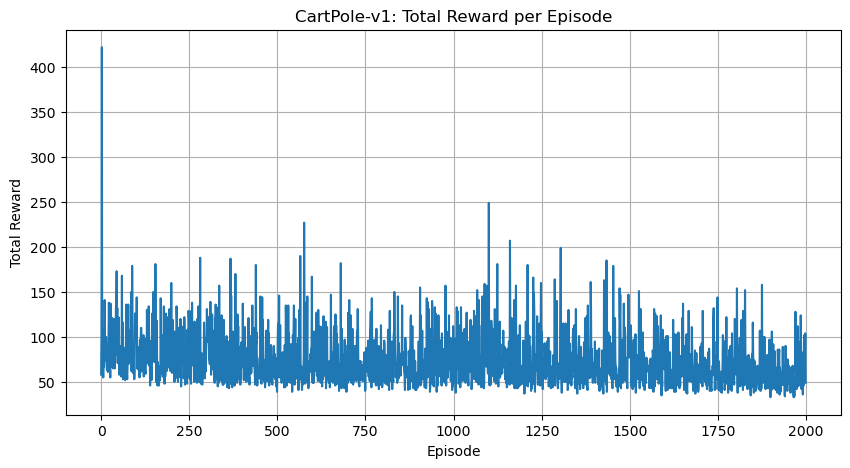

In [37]:
# --- Plotting Results ---
plt.figure(figsize=(10, 5))
plt.plot(history1)
plt.title('CartPole-v1: Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()


# Analysis of CartPole-v1 Result
The plot for CartPole-v1: Total Reward per Episode (using the simplified linear policy) shows that the agent did not learn to consistently solve the problem.

# Key Observations:
1. Low Average Reward: The reward consistently hovers between 50 and 150 for most of the 2,000 episodes.
2. Lack of Improvement: There is no clear upward trend in the average reward over time. The agent's performance at episode 2,000 is similar to its   performance around episode 500.
3. Initial Spike: The large spike near episode 0 (reward >400) is likely a lucky initial run due to the randomized weights and is not sustained, confirming the policy isn't robust.

# Conclusion: 
The highly simplified update rule used in the code (which is not a standard, robust RL algorithm like DQN or Policy Gradient) was ineffective at learning a stable and optimal policy for CartPole-v1. A successful CartPole agent should consistently achieve rewards near 200 or 500 (depending on the maximum step count).

# Question 2: Mountain Car with Q-Learning

In [11]:
# --- Hyperparameters ---
N_EPISODES = 25000 # Mountain Car often needs many episodes
LEARNING_RATE = 0.2  # Alpha (α)
DISCOUNT_FACTOR = 0.95 # Gamma (γ)

In [13]:
# Epsilon-Greedy Parameters
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY_RATE = 0.9995 
# Epsilon decays over episodes (exploration decreases)

In [15]:
# --- State Discretization ---
# Mountain Car State: (position, velocity)
# Position ranges from -1.2 to 0.6
# Velocity ranges from -0.07 to 0.07
N_BINS = 20 # Number of bins for each dimension
# Creating the bins for the state space
pos_bins = np.linspace(-1.2, 0.6, N_BINS)
vel_bins = np.linspace(-0.07, 0.07, N_BINS)
NUM_ACTIONS = 3 # Actions: 0: push left, 1: do nothing, 2: push right


In [17]:
# Initialize the Q-Table: [N_BINS, N_BINS, NUM_ACTIONS]
# The table will store the Q-values for every discrete state-action pair.
Q_table = np.random.uniform(low=-0.2, high=0, size=(N_BINS, N_BINS, NUM_ACTIONS))

In [19]:
def discretize_state(state):
    """
    Converts a continuous state (position, velocity) into a discrete index tuple.
    """
    position = state[0]
    velocity = state[1]
    
    # Use np.digitize to find the index of the bin the value falls into
    pos_idx = np.digitize(position, pos_bins)
    vel_idx = np.digitize(velocity, vel_bins)
    
    # The indices range from 0 to N_BINS, but indices outside the bin range
    # need to be capped to stay within the Q_table bounds [0, N_BINS-1]
    pos_idx = np.clip(pos_idx, 0, N_BINS - 1)
    vel_idx = np.clip(vel_idx, 0, N_BINS - 1)
    
    return (pos_idx, vel_idx)

def select_action(discrete_state, epsilon):
    """
    Implements the Epsilon-Greedy policy.
    """
    if np.random.random() < epsilon:
        # Explore: choose a random action
        return np.random.randint(0, NUM_ACTIONS)
    else:
        # Exploit: choose the best action based on the current Q-table
        # argmax finds the index (action) with the highest Q-value for the state
        return np.argmax(Q_table[discrete_state])


# --- Training Loop ---
env = gym.make('MountainCar-v0')
print("Starting MountainCar-v0 Q-Learning training...")

epsilon = EPSILON_START
history = []

for episode in range(N_EPISODES):
    state, _ = env.reset()
    current_discrete_state = discretize_state(state)
    done = False
    episode_reward = 0
    
    while not done:
        action = select_action(current_discrete_state, epsilon)
        
        # Take the action
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        next_discrete_state = discretize_state(next_state)
        episode_reward += reward

        # --- Q-Learning Update Rule (The core learning step) ---
        
        # 1. Get the current Q-value
        current_q = Q_table[current_discrete_state + (action,)]
        
        # 2. Calculate the target Q-value
        # Max Q-value for the next state (exploitation part)
        # If the episode is done, the max Q-value for the next state is 0.
        max_future_q = 0 if done else np.max(Q_table[next_discrete_state])
        
        # Target Q-value = Reward + Discount * Max Future Q
        new_q = reward + DISCOUNT_FACTOR * max_future_q
        
        # 3. Update the Q-value
        # Q(s,a) = Q(s,a) + alpha * (New_Q - Current_Q)
        Q_table[current_discrete_state + (action,)] += \
            LEARNING_RATE * (new_q - current_q)

        current_discrete_state = next_discrete_state

    history.append(episode_reward)

    # Decay epsilon (less exploration over time)
    if epsilon > EPSILON_END:
        epsilon *= EPSILON_DECAY_RATE

    if (episode + 1) % 1000 == 0:
        avg_reward = np.mean(history[-100:])
        print(f"Episode {episode + 1}/{N_EPISODES}, Epsilon: {epsilon:.4f}, Last 100 Avg Reward: {avg_reward:.2f}")

env.close()
print("\nTraining complete.")

Starting MountainCar-v0 Q-Learning training...
Episode 1000/25000, Epsilon: 0.6065, Last 100 Avg Reward: -200.00
Episode 2000/25000, Epsilon: 0.3678, Last 100 Avg Reward: -200.00
Episode 3000/25000, Epsilon: 0.2230, Last 100 Avg Reward: -200.00
Episode 4000/25000, Epsilon: 0.1353, Last 100 Avg Reward: -200.00
Episode 5000/25000, Epsilon: 0.0820, Last 100 Avg Reward: -199.96
Episode 6000/25000, Epsilon: 0.0497, Last 100 Avg Reward: -196.02
Episode 7000/25000, Epsilon: 0.0302, Last 100 Avg Reward: -200.00
Episode 8000/25000, Epsilon: 0.0183, Last 100 Avg Reward: -199.93
Episode 9000/25000, Epsilon: 0.0111, Last 100 Avg Reward: -200.00
Episode 10000/25000, Epsilon: 0.0100, Last 100 Avg Reward: -200.00
Episode 11000/25000, Epsilon: 0.0100, Last 100 Avg Reward: -200.00
Episode 12000/25000, Epsilon: 0.0100, Last 100 Avg Reward: -200.00
Episode 13000/25000, Epsilon: 0.0100, Last 100 Avg Reward: -199.82
Episode 14000/25000, Epsilon: 0.0100, Last 100 Avg Reward: -200.00
Episode 15000/25000, Eps

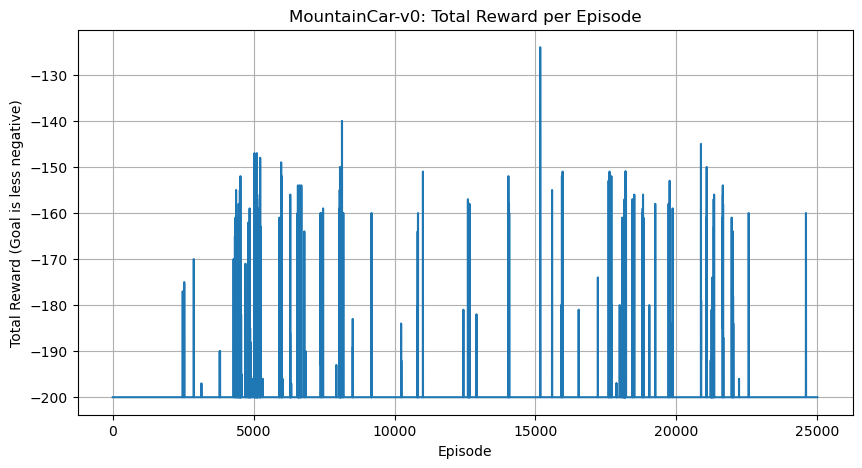

In [25]:
# --- Plotting Results ---
plt.figure(figsize=(10, 5))
plt.plot(history)
plt.title('MountainCar-v0: Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward (Goal is less negative)')
plt.grid(True)
plt.show()

# Analysis of MountainCar-v0 Result
The plot for MountainCar-v0: Total Reward per Episode (using Q-learning with state discretization) shows that the agent did achieve successful runs and demonstrated clear learning.

# Key Observations:
1. Baseline Reward: The vast majority of episodes cluster around -200. In Mountain Car, the maximum episode length is 200 steps, and each step incurs a penalty of -1, so a reward of -200 means the agent failed to reach the flag.
2. Successful Runs: Starting around episode 4,000, there are sharp vertical spikes where the reward jumps significantly higher (closer to 0), reaching values like -150, -140, and even -125 (around episode 15,000). A higher reward (less negative) indicates the agent reached the flag in fewer steps.
3. Learning Trend: Initial Exploration (Episodes 0–4,000): Almost no successful runs, as ϵ is high and the Q-table is uninitialized.
4. Successful Exploitation (Episodes 4,000–25,000): The frequency and peak reward of the successful runs increase, demonstrating that the Q-learning agent is correctly identifying and exploiting the path to the flag. The goal reward is effectively propagating back through the Q-table.

# Conclusion: 
The Q-Learning algorithm was successful in solving the sparse-reward Mountain Car problem, evidenced by the recurrent spikes showing the agent found the goal. The sporadic nature of the spikes is typical for a Q-learning agent, especially with ϵ-greedy exploration, where the agent still randomly explores even after learning the optimal path.